# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
from itertools import product
import random

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_data_utils import split_cell_data, channel_combo_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    summarize_cell_data,
    plot_feature_distributions,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

random.seed(42)

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL_1`: First well identifier used for testing configuration
- `TEST_WELL_2`: Second well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL_1 = "A2"
TEST_WELL_2 = "A3"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_1}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=25000)

merge_final_fp_2 = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_2}, "merge_final", "parquet")
)
cell_data_2 = load_parquet_subset(merge_final_fp_2, n_rows=25000)

cell_data = pd.concat([cell_data, cell_data_2], ignore_index=True)
cell_data

Reading first 25,000 rows from brieflow_output/merge/parquets/P-1_W-A2__merge_final.parquet
Reading first 25,000 rows from brieflow_output/merge/parquets/P-1_W-A3__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A2,247,331,1480.021169,1480.377016,64,195,100.884058,667.420290,...,0.052566,0.023677,0.049437,0.026188,0.028350,4,0.621381,58.075517,58.598915,105.017930
1,1,A2,89,303,1479.256459,1478.702392,17,1478,670.810811,666.243243,...,0.083382,0.070938,0.006916,0.030246,0.023903,2,0.299587,59.117186,74.055317,72.698858
2,1,A2,1397,492,1478.945338,1478.295820,332,1700,670.204082,669.857143,...,0.057667,0.013410,0.016663,0.012728,0.008706,2,0.152778,65.954507,73.329230,67.249799
3,1,A2,726,420,1480.913760,1477.873062,173,1495,669.742857,667.814286,...,0.055708,0.023220,0.040241,0.026208,0.021034,5,0.511211,57.466570,67.315904,168.776398
4,1,A2,382,521,1478.798479,1477.577947,92,2002,668.827586,667.465517,...,0.070313,0.109815,0.097967,0.043925,0.022338,5,0.630890,41.623418,48.306766,152.621315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A3,1472,550,1677.707250,1556.076949,339,2146,719.257485,120.544910,...,0.013509,0.059578,0.044283,0.041214,0.035758,4,0.290842,71.728589,96.302415,143.820056
49996,1,A3,1109,294,1274.411508,1428.880554,255,2183,1190.595238,86.833333,...,0.064699,0.035719,0.010172,0.030788,0.009553,2,0.232517,84.665726,92.560594,50.446621
49997,1,A3,1489,612,1469.931946,1268.387510,360,311,98.505495,617.747253,...,0.024125,0.022059,0.018263,0.003074,0.013223,4,0.266304,74.896343,91.076568,178.302909
49998,1,A3,980,582,1617.934564,1640.813758,232,2130,705.153061,710.367347,...,0.184189,0.066848,0.029291,0.024752,0.039386,5,0.561905,54.583084,59.292045,147.347400


In [5]:
for col in cell_data.columns:
    print(col)

plate
well
tile
cell_0
i_0
j_0
site
cell_1
i_1
j_1
distance
fov_distance_0
fov_distance_1
sgRNA_0
gene_symbol_0
mapped_single_gene
channels_min
nucleus_i
nucleus_j
nucleus_bounds_0
nucleus_bounds_1
nucleus_bounds_2
nucleus_bounds_3
cell_i
cell_j
cell_bounds_0
cell_bounds_1
cell_bounds_2
cell_bounds_3
cytoplasm_i
cytoplasm_j
cytoplasm_bounds_0
cytoplasm_bounds_1
cytoplasm_bounds_2
cytoplasm_bounds_3
nucleus_DAPI_int
nucleus_ACA_int
nucleus_MITOTRACKER_int
nucleus_VIMENTIN_int
nucleus_CENPT_int
nucleus_ITGB1_int
nucleus_PHALLOIDIN_int
nucleus_WGA_int
nucleus_DAPI_mean
nucleus_ACA_mean
nucleus_MITOTRACKER_mean
nucleus_VIMENTIN_mean
nucleus_CENPT_mean
nucleus_ITGB1_mean
nucleus_PHALLOIDIN_mean
nucleus_WGA_mean
nucleus_DAPI_std
nucleus_ACA_std
nucleus_MITOTRACKER_std
nucleus_VIMENTIN_std
nucleus_CENPT_std
nucleus_ITGB1_std
nucleus_PHALLOIDIN_std
nucleus_WGA_std
nucleus_DAPI_max
nucleus_ACA_max
nucleus_MITOTRACKER_max
nucleus_VIMENTIN_max
nucleus_CENPT_max
nucleus_ITGB1_max
nucleus_PHALLOIDI

## <font color='red'>SET PARAMETERS</font>

### Cell Data Metadata

- `METADATA_COLS_FP`: Path to TSV to store metadata cols.
- `METADATA_COLS`: Columns in cell data with metadata (use output above).

In [6]:
METADATA_COLS_FP = "config/cell_data_metadata_cols.tsv"
METADATA_COLS = [
    "plate",
    "well",
    "tile",
    "cell_0",
    "i_0",
    "j_0",
    "site",
    "cell_1",
    "i_1",
    "j_1",
    "distance",
    "fov_distance_0",
    "fov_distance_1",
    "sgRNA_0",
    "gene_symbol_0",
    "mapped_single_gene",
    "channels_min",
    "nucleus_i",
    "nucleus_j",
    "nucleus_bounds_0",
    "nucleus_bounds_1",
    "nucleus_bounds_2",
    "nucleus_bounds_3",
    "cell_i",
    "cell_j",
    "cell_bounds_0",
    "cell_bounds_1",
    "cell_bounds_2",
    "cell_bounds_3",
    "cytoplasm_i",
    "cytoplasm_j",
    "cytoplasm_bounds_0",
    "cytoplasm_bounds_1",
    "cytoplasm_bounds_2",
    "cytoplasm_bounds_3",
]

In [7]:
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")

metadata, features = split_cell_data(cell_data, METADATA_COLS)
print(metadata.shape, features.shape)

(50000, 35) (50000, 3569)


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes

### Evaluate splitting

- `COLLAPSE_COLS`: Cell data columns to collapse on when creating a summary of cell counts. This will show the number of cells in each cell class for these particular columns. Ex: `["sgRNA_0", "gene_symbol_0"]`.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`.

**Notes**: 
- We generate cell classes for each of the classes listed in the classifier and an "all" class. So for a classifier that splits by mitotic or interphase the final classes will be `["mitotic", "interphase", "all"]`.
- You must import necessary packages for the classifier in this notebook and add them to `scripts/aggregate/split_datasets.py` as well. Ex `import numpy as np` if the classifier requires `numpy`.

In [8]:
CLASSIFIER_PATH = "config/binary_xgb_none_model.dill"
MONTAGE_CHANNEL = "DAPI"
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_kilimanjaro/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_kilimanjaro/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Removing 1 rows with NaN values in features
Cell class counts:
class
Interphase    32140
Mitotic       17859
Name: count, dtype: int64

Cell class confidences:


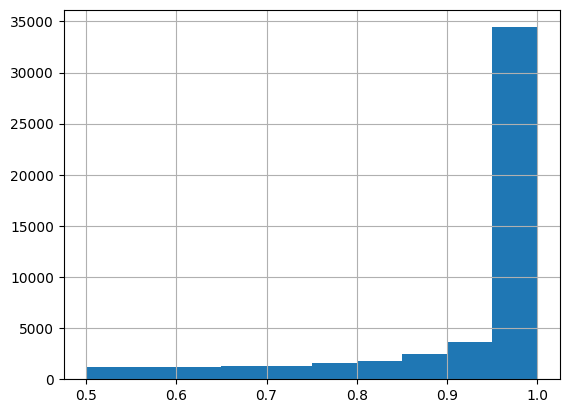

In [9]:
import numpy as np

classifier = CellClassifier.load(CLASSIFIER_PATH)
classified_metadata, classified_features = classifier.classify_cells(metadata, features)

# Create config var for cell classes
CELL_CLASSES = list(classified_metadata["class"].unique())

# Show cell class counts and distribution
print("Cell class counts:")
print(classified_metadata["class"].value_counts())

print("\nCell class confidences:")
classified_metadata["confidence"].hist()
plt.show()

Montages of cell classes:


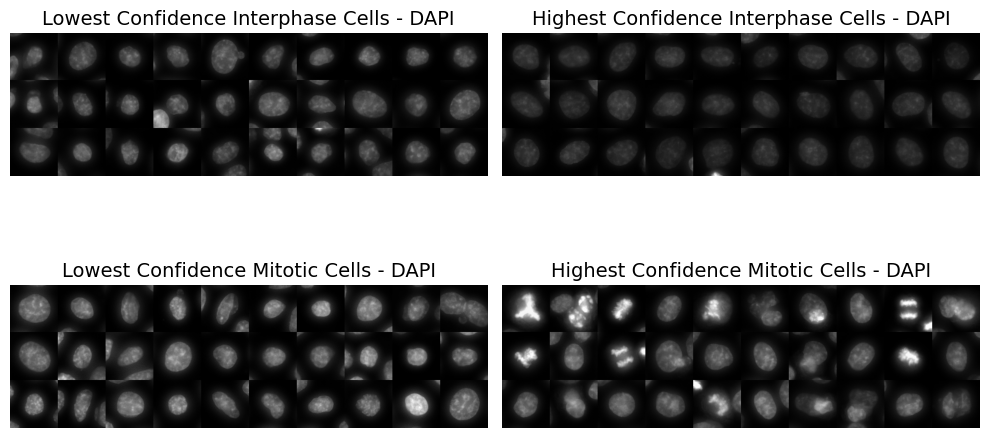

Split cell data summary:


,Stage,Count,Percent
0,Raw Data,49999,100.00
1,Interphase cells,32140,64.28
2,Interphase sgRNA_0,8246,16.49
3,Interphase gene_symbol_0,4510,9.02
4,Mitotic cells,17859,35.72
5,Mitotic sgRNA_0,5584,11.17
6,Mitotic gene_symbol_0,3711,7.42


In [10]:
cell_classes = list(classified_metadata["class"].unique()) + ["all"]

classified_metadata_copy = classified_metadata.copy(deep=True)
classified_metadata_copy = add_filenames(classified_metadata_copy, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_metadata_copy[classified_metadata_copy["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(
            title_templates[ascending].format(
                cell_class=cell_class, channel=MONTAGE_CHANNEL
            )
        )

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

print("Montages of cell classes:")
plt.tight_layout()
plt.show()

print("Split cell data summary:")
summary_df = summarize_cell_data(classified_metadata, CELL_CLASSES, COLLAPSE_COLS)
display(summary_df)

## <font color='red'>SET PARAMETERS</font>

### Aggregate by channel combos

- `CHANNEL_COMBOS`: Combinations of channels to aggregate by. This is a list of lists with channel names, ex `[["DAPI", "CENPA"], ["DAPI", "WGA"]]`.
- `AGGREGATE_COMBO_FP`: Location of aggregate combinations dataframe.
- `TEST_CELL_CLASS`: Cell class to configure aggregate params with. Can be any of the cell classes or `all`.
- `TEST_CHANNEL_COMBO`: Channel combo to configure aggregate params with; must be one of the channel combos. Ex `["DAPI", "CENPA"]`.

In [11]:
CHANNEL_COMBOS = [
    # All channels together
    ["DAPI", "ACA", "MITOTRACKER", "VIMENTIN", "CENPT", "ITGB1", "PHALLOIDIN", "WGA"],
    # All but phalloidin -- didn't work well per Kaitlyn
    ["DAPI", "ACA", "MITOTRACKER", "VIMENTIN", "CENPT", "ITGB1", "WGA"],
    # Nuclear clustering (DAPI + centromere markers)
    ["DAPI", "ACA", "CENPT"],
    # Further permutations of nuclear clustering
    ["DAPI", "CENPT"],
    ["ACA", "CENPT"],
    ["DAPI"],
    # Mitochondria + membrane + nuclear reference
    ["DAPI", "MITOTRACKER", "WGA"],
    # Cytoskeleton + membrane protein + nuclear reference
    ["DAPI", "VIMENTIN", "PHALLOIDIN", "ITGB1"],
    # Same as above but without phalloidin -- didn't work well per Kaitlyn
    ["DAPI", "VIMENTIN", "ITGB1"],
]
AGGREGATE_COMBO_FP = "config/aggregate_combo.tsv"

TEST_CELL_CLASS = "all"
TEST_CHANNEL_COMBO = ["DAPI", "ACA", "MITOTRACKER", "VIMENTIN", "CENPT", "ITGB1", "WGA"]

In [12]:
# determine cell classes and channel combos
channel_combos = ["_".join(combo) for combo in CHANNEL_COMBOS]

# Load merge wildcard combos
MERGE_COMBO_FP = Path(config["merge"]["merge_combo_fp"])
merge_wildcard_combos = pd.read_csv(MERGE_COMBO_FP, sep="\t")

# Generate aggregate wildcard combos
aggregate_wildcard_combos = pd.DataFrame(
    product(
        merge_wildcard_combos.itertuples(index=False, name=None),
        cell_classes,
        channel_combos,
    ),
    columns=["plate_well", "cell_class", "channel_combo"],
)
aggregate_wildcard_combos[["plate", "well"]] = pd.DataFrame(aggregate_wildcard_combos["plate_well"].tolist(), index=aggregate_wildcard_combos.index)
aggregate_wildcard_combos = aggregate_wildcard_combos.drop(columns="plate_well")

# Save aggregate wildcard combos
aggregate_wildcard_combos.to_csv(AGGREGATE_COMBO_FP, sep="\t", index=False)

print("Aggregate wildcard combos:")
aggregate_wildcard_combos

Aggregate wildcard combos:


,cell_class,channel_combo,plate,well
0,Interphase,DAPI_ACA_MITOTRACKER_VIMENTIN_CENPT_ITGB1_PHAL...,1,A2
1,Interphase,DAPI_ACA_MITOTRACKER_VIMENTIN_CENPT_ITGB1_WGA,1,A2
2,Interphase,DAPI_ACA_CENPT,1,A2
3,Interphase,DAPI_CENPT,1,A2
4,Interphase,ACA_CENPT,1,A2
...,...,...,...,...
130,all,ACA_CENPT,1,B3
131,all,DAPI,1,B3
132,all,DAPI_MITOTRACKER_WGA,1,B3
133,all,DAPI_VIMENTIN_PHALLOIDIN_ITGB1,1,B3


In [13]:
# subset cell class
if TEST_CELL_CLASS != "all":
    cell_class_mask = classified_metadata["class"] == TEST_CELL_CLASS
    class_metadata = classified_metadata[cell_class_mask]
    class_features = classified_features[cell_class_mask]
else:
    class_metadata = classified_metadata
    class_features = classified_features

# subset features
all_channels = config["phenotype"]["channel_names"]
class_features = channel_combo_subset(class_features, TEST_CHANNEL_COMBO, all_channels)

# copy metadata and features for later eval
dataset_metadata = class_metadata.copy()
dataset_features = class_features.copy()

# preview metadata and features
display(class_metadata)
display(class_features)

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_bounds_2,cell_bounds_3,cytoplasm_i,cytoplasm_j,cytoplasm_bounds_0,cytoplasm_bounds_1,cytoplasm_bounds_2,cytoplasm_bounds_3,class,confidence
0,1,A2,247,331,1480.021169,1480.377016,64,195,100.884058,667.420290,...,1520,1522,1478.753544,1480.523982,1446,1439,1520,1522,Interphase,0.999359
1,1,A2,89,303,1479.256459,1478.702392,17,1478,670.810811,666.243243,...,1510,1523,1469.737493,1472.584518,1436,1429,1510,1523,Mitotic,0.861136
2,1,A2,1397,492,1478.945338,1478.295820,332,1700,670.204082,669.857143,...,1519,1516,1480.429337,1477.937755,1443,1437,1519,1516,Mitotic,0.997463
3,1,A2,726,420,1480.913760,1477.873062,173,1495,669.742857,667.814286,...,1521,1514,1478.121064,1478.254662,1439,1447,1521,1514,Interphase,0.925573
4,1,A2,382,521,1478.798479,1477.577947,92,2002,668.827586,667.465517,...,1505,1514,1478.619102,1472.955121,1458,1436,1505,1514,Mitotic,0.878041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A3,1472,550,1677.707250,1556.076949,339,2146,719.257485,120.544910,...,1744,1618,1675.214598,1551.249280,1596,1488,1744,1618,Interphase,0.999948
49996,1,A3,1109,294,1274.411508,1428.880554,255,2183,1190.595238,86.833333,...,1322,1477,1272.030607,1424.121578,1227,1374,1322,1477,Interphase,0.999824
49997,1,A3,1489,612,1469.931946,1268.387510,360,311,98.505495,617.747253,...,1512,1322,1463.632309,1270.646356,1418,1219,1512,1322,Mitotic,0.999118
49998,1,A3,980,582,1617.934564,1640.813758,232,2130,705.153061,710.367347,...,1655,1681,1610.180797,1642.483696,1572,1600,1655,1681,Interphase,0.998209


,nucleus_DAPI_int,nucleus_ACA_int,nucleus_MITOTRACKER_int,nucleus_VIMENTIN_int,nucleus_CENPT_int,nucleus_ITGB1_int,nucleus_WGA_int,nucleus_DAPI_mean,nucleus_ACA_mean,nucleus_MITOTRACKER_mean,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,12901967,2216010,2236741,11910409,2340713,667488,2549728,13006.015121,2233.881048,2254.779234,...,0.052566,0.023677,0.049437,0.026188,0.028350,4,0.621381,58.075517,58.598915,105.017930
1,12664217,2441540,2861859,14595097,2448697,934991,2127157,12118.867943,2336.401914,2738.621053,...,0.083382,0.070938,0.006916,0.030246,0.023903,2,0.299587,59.117186,74.055317,72.698858
2,23978897,2043008,1901762,9411421,2701896,544246,1505972,38551.281350,3284.578778,3057.495177,...,0.057667,0.013410,0.016663,0.012728,0.008706,2,0.152778,65.954507,73.329230,67.249799
3,13297386,1924089,2284681,12618458,1894688,572008,2103387,12885.063953,1864.427326,2213.838178,...,0.055708,0.023220,0.040241,0.026208,0.021034,5,0.511211,57.466570,67.315904,168.776398
4,12788036,1864402,2312964,9532986,2057754,532621,1807280,16207.903676,2362.993663,2931.513308,...,0.070313,0.109815,0.097967,0.043925,0.022338,5,0.630890,41.623418,48.306766,152.621315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,26524008,5574683,5085099,38963781,6413347,1541327,5792230,9071.138167,1906.526334,1739.089945,...,0.013509,0.059578,0.044283,0.041214,0.035758,4,0.290842,71.728589,96.302415,143.820056
49996,12447081,2222336,2406861,7860024,1483784,691489,1712644,9065.608886,1618.598689,1752.994173,...,0.064699,0.035719,0.010172,0.030788,0.009553,2,0.232517,84.665726,92.560594,50.446621
49997,22767183,3012626,2879086,13543596,2883630,948071,3006129,18228.329063,2412.030424,2305.112890,...,0.024125,0.022059,0.018263,0.003074,0.013223,4,0.266304,74.896343,91.076568,178.302909
49998,18372401,2843818,2648422,8542137,1969395,892297,3054146,10275.392058,1590.502237,1481.220358,...,0.184189,0.066848,0.029291,0.024752,0.039386,5,0.561905,54.583084,59.292045,147.347400


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == True", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbations. This is the column that aggregation takes place on. Ex "gene_symbol_0".

In [14]:
FILTER_QUERIES = ["mapped_single_gene == True"]
PERTURBATION_NAME_COL = "gene_symbol_0"

Query 'mapped_single_gene == True' filtered out 25650 cells
Found 24349 cells with assigned perturbations
Unique populations: 4858
                               column  percent_na
0          cytoplasm_DAPI_mean_frac_0    0.791449
1           cytoplasm_ACA_mean_frac_0    0.791449
2   cytoplasm_MITOTRACKER_mean_frac_0    0.791449
3      cytoplasm_VIMENTIN_mean_frac_0    0.791449
4         cytoplasm_CENPT_mean_frac_0    0.791449
5         cytoplasm_ITGB1_mean_frac_0    0.791449
6           cytoplasm_WGA_mean_frac_0    0.791449
14         cytoplasm_DAPI_radial_cv_0    0.791449
15          cytoplasm_ACA_radial_cv_0    0.791449
16  cytoplasm_MITOTRACKER_radial_cv_0    0.791449
17     cytoplasm_VIMENTIN_radial_cv_0    0.791449
18        cytoplasm_CENPT_radial_cv_0    0.791449
19        cytoplasm_ITGB1_radial_cv_0    0.791449
20          cytoplasm_WGA_radial_cv_0    0.791449


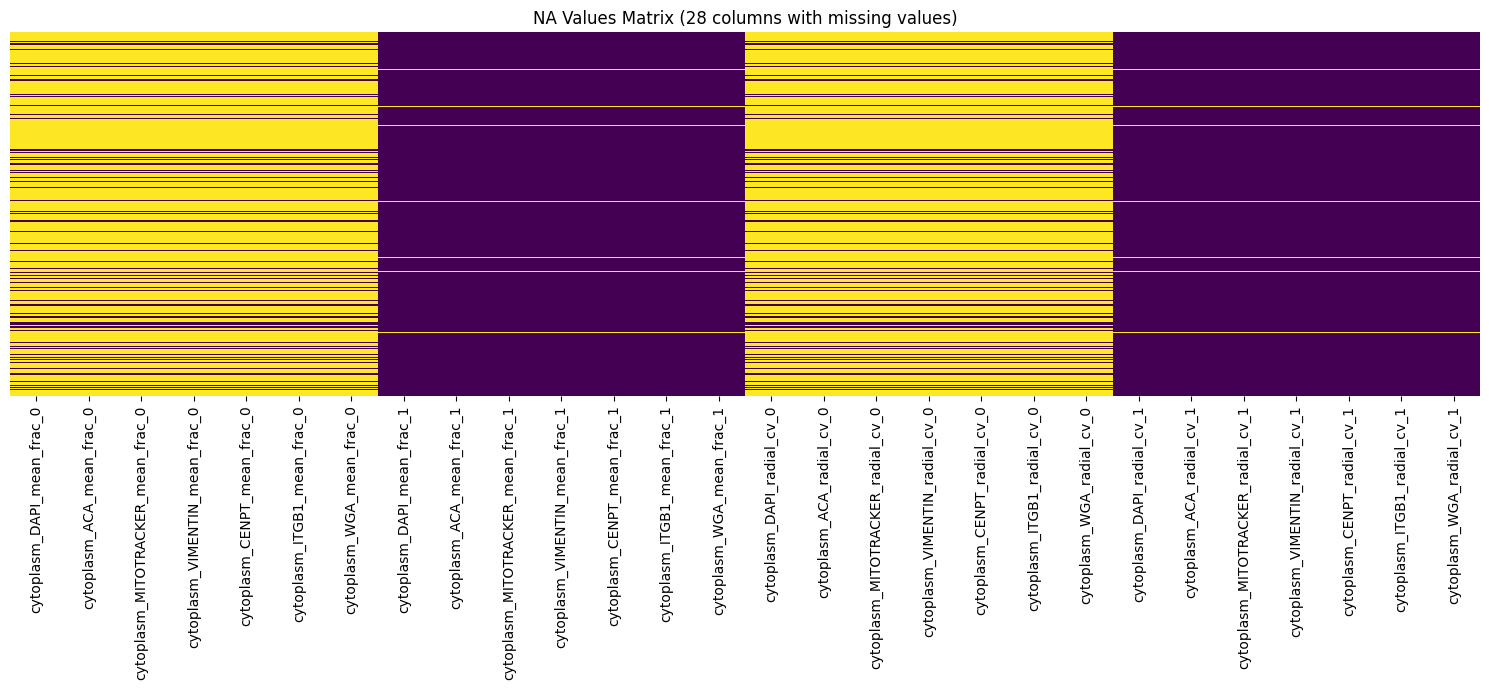

In [15]:
qf_metadata, qf_features = query_filter(class_metadata, class_features, FILTER_QUERIES)

pf_metadata, pf_features = perturbation_filter(
    qf_metadata, qf_features, PERTURBATION_NAME_COL
)
print(f"Unique populations: {metadata[PERTURBATION_NAME_COL].nunique()}")

summary_df, fig = nas_summary(pf_features)
print(summary_df[summary_df["percent_na"] > 0.1])
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [16]:
DROP_COLS_THRESHOLD = 0.1
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [17]:
# Filter by missing values
mvf_metadata, mvf_features = missing_values_filter(
    pf_metadata,
    pf_features,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

mvf_metadata.shape, mvf_features.shape

Dropping 14 columns with ≥10.0% missing values
Dropped 0 rows with ≥1.0% missing values
Imputing 14 columns with remaining missing values using batched KNN
Imputing for batch 1 with 588 NA rows


((24349, 37), (24349, 3030))

## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [18]:
CONTAMINATION = 0.01

In [19]:
# Filter by intensity outliers
if_metadata, if_features = intensity_filter(
    mvf_metadata,
    mvf_features,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

if_metadata.shape, if_features.shape

((24105, 37), (24105, 3030))

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations. Only needed if you want your controls to have different perturbation names, ex `sgRNA_0`. Otherwise, can leave this as `None`.

In [20]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting"
PERTURBATION_ID_COL = "sgRNA_0"

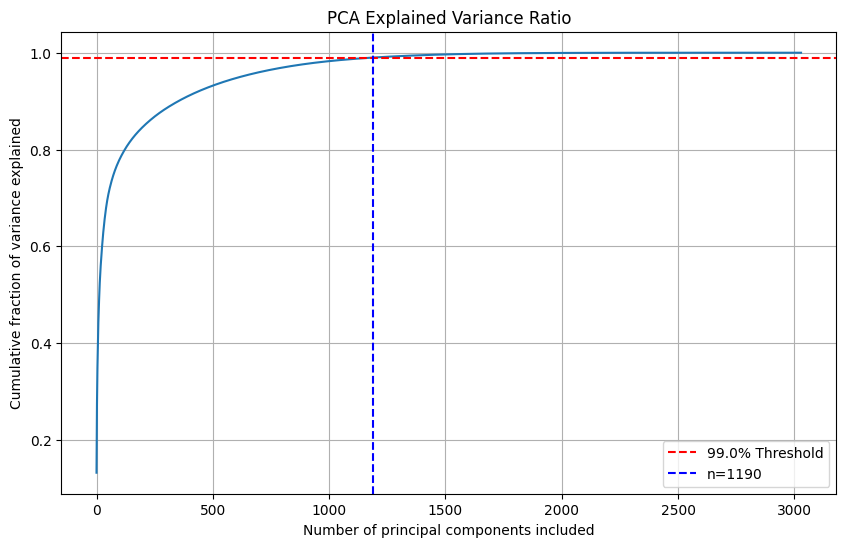

In [21]:
pad_metadata, pad_features = prepare_alignment_data(
    if_metadata, if_features, BATCH_COLS, PERTURBATION_NAME_COL, CONTROL_KEY, PERTURBATION_ID_COL
)

n_components, fig = pca_variance_plot(
    pad_features, variance_threshold=0.99
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `VARIANCE_OR_NCOMP`: Variance or number of components to keep after PCA.
- `NUM_ALIGN_BATCHES`: Number of batches to use when aligning, usually `1`. Increase this if you are running out of memory while aligning. We were able to barely fit 8 plates with 6 wells each in 1 TB of memory with `NUM_ALIGN_BATCHES=1`.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `median`.

While we use a simplified aggregate method in the notebook, the way this works during a normal run is:
1) Take a subset of 1,000,000 cells, or the entire dataset, whichever is smaller and compute a PCA transform with `VARIANCE_OR_NCOMP`.
2) Subset the entire dataset `NUM_BATCHES` number of times and align cells in this batch.
3) Aggregate across all aligned cell data.

In [22]:
VARIANCE_OR_NCOMP = 0.99
NUM_ALIGN_BATCHES = 1
AGG_METHOD = "median"

In [23]:
pca_embeddings = embed_by_pca(
    pad_features, pad_metadata, variance_or_ncomp=VARIANCE_OR_NCOMP, batch_col="batch_values"
)

tvn_normalized = tvn_on_controls(
    pca_embeddings, pad_metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, pad_metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=pad_metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([pad_metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

/lab/ops_analysis/cheeseman/kilimanjaro-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/kilimanjaro-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/kilimanjaro-analysis/brieflow/workflow/lib/aggregate/align.py:174: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list,

/lab/ops_analysis/cheeseman/kilimanjaro-analysis/brieflow/workflow/lib/aggregate/eval_aggregate.py:130: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_orig = df_orig.groupby(["Feature", "plate_well"], group_keys=False).apply(
/lab/ops_analysis/cheeseman/kilimanjaro-analysis/brieflow/workflow/lib/aggregate/eval_aggregate.py:136: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_aligned = df_aligned.groupby(["Feature"

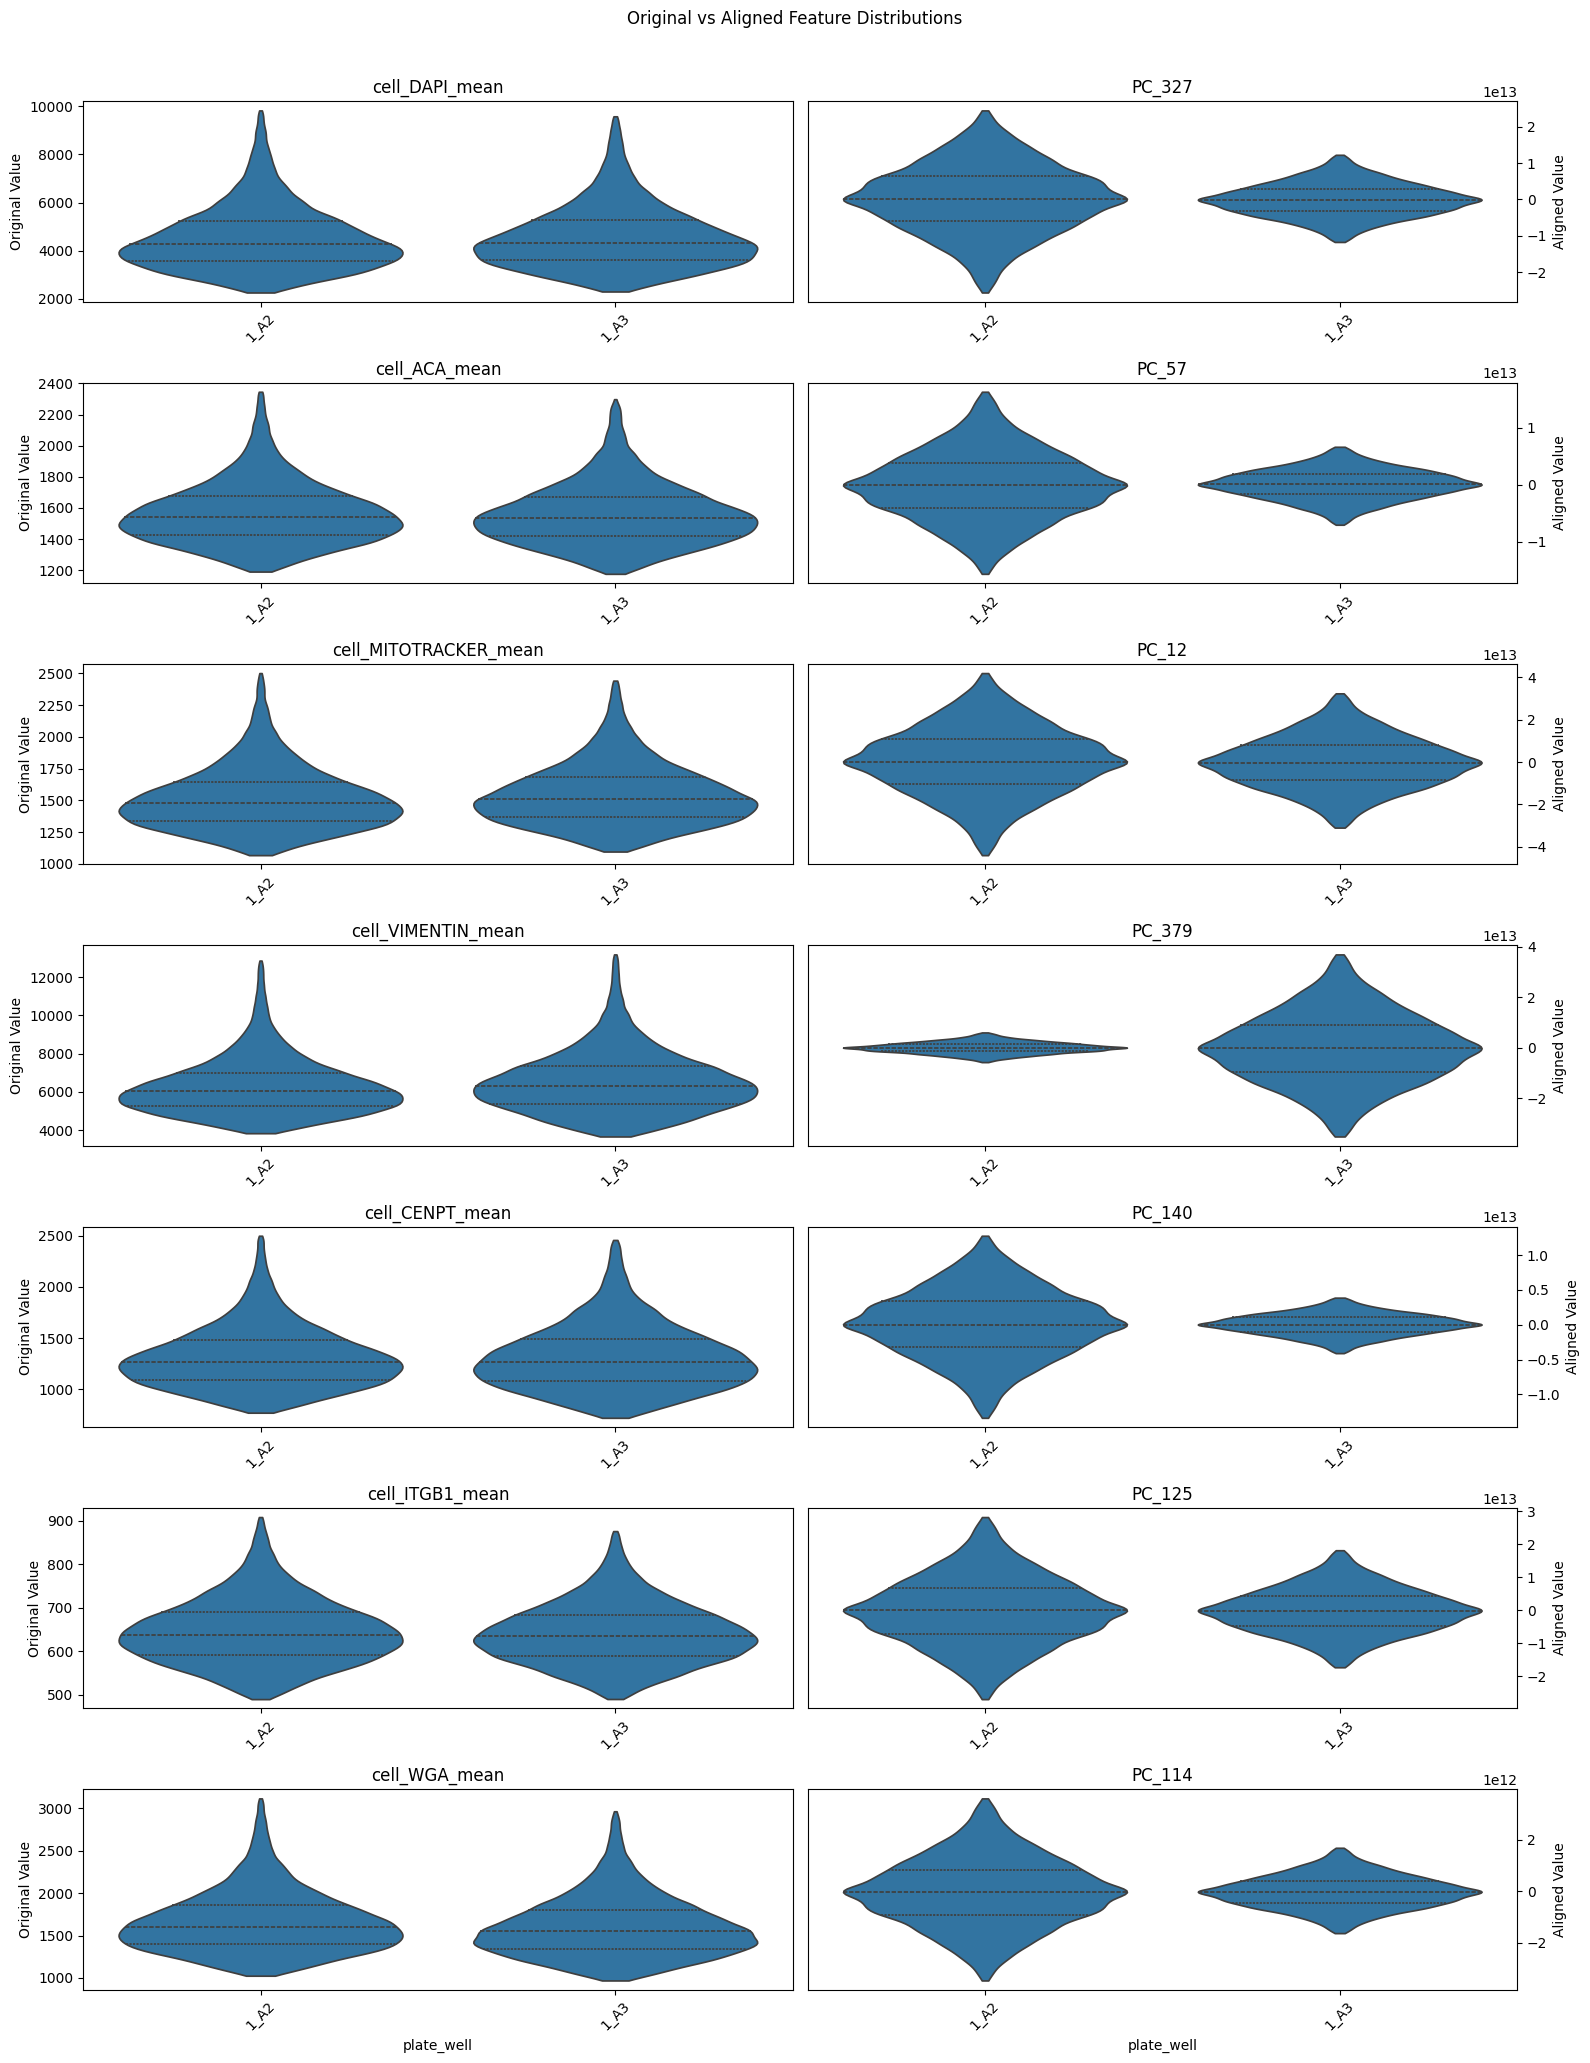

In [24]:
original_feature_cols = [col for col in dataset_features.columns if ("cell_" in col and col.endswith("_mean"))]
pc_cols = [col for col in aggregated_cell_data.columns if col.startswith("PC_")]
aligned_feature_cols = random.sample(pc_cols, k=min(len(original_feature_cols), len(pc_cols)))

original_cell_data = pd.concat([dataset_metadata, dataset_features], axis=1)
original_cell_data

feature_distributions_fig = plot_feature_distributions(
    original_feature_cols,
    original_cell_data,
    aligned_feature_cols,
    aligned_cell_data,
)
plt.show()

## Add aggregate parameters to config file

In [25]:
# Add aggregate section
config["aggregate"] = {
    "metadata_cols_fp": METADATA_COLS_FP,
    "collapse_cols": COLLAPSE_COLS,
    "classifier_path": CLASSIFIER_PATH,
    "aggregate_combo_fp": AGGREGATE_COMBO_FP,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "variance_or_ncomp": VARIANCE_OR_NCOMP,
    "num_align_batches": NUM_ALIGN_BATCHES,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)